# Finite elements for IVBP with Neumann conditions

## Start simple: BVP with Neumann BC

Example 6.10 - Inhomogeneous Neumann BVP

This example is taken from Gockenbach, Sect. 6.5.

In [165]:
from sympy import *
init_printing(use_unicode=True)

In [166]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import quad
from scipy.linalg import solve_banded

In [167]:
init_session()

IPython console for SymPy 1.10.1 (Python 3.9.12-64-bit) (ground types: python)

These commands were executed:
>>> from sympy import *
>>> x, y, z, t = symbols('x y z t')
>>> k, m, n = symbols('k m n', integer=True)
>>> f, g, h = symbols('f g h', cls=Function)
>>> init_printing()

Documentation can be found at https://docs.sympy.org/1.10.1/



In [168]:
u = symbols('u', cls=Function)
l = Symbol('l', real=True, positive=True)
i = Symbol('i', integer=True)
h = Symbol('h', real=True, positive=True)

In [169]:
ode = Eq((-u(x).diff(x, x)),(x-1/2), domain=Interval(0,1))

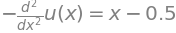

In [170]:
ode

In [171]:
ics = {
    u(x).diff(x).subs(x, 0) : 0,
    u(x).diff(x).subs(x, l) : 0,
    u(0) : 0,
}

In [172]:
srepr(ode)

"Equality(Mul(Integer(-1), Derivative(Function('u')(Symbol('x')), Tuple(Symbol('x'), Integer(2)))), Add(Symbol('x'), Float('-0.5', precision=53)))"

In [173]:
def basis(x, i):
    return np.piecewise(x, [x < (i-1)*h,
                            ((i-1)*h <= x) & (x <= i*h),
                            (i*h < x) & (x <= (i+1)*h),
                            x > (i+1)*h],
                        [0, (x - (i - 1) * h)/h, -(x - (i + 1) * h)/h, 0])

vbasis = np.vectorize(basis)

## Build the piecewise polynomials basis

The following is a single element $\phi_j (x)$ of the basis of piecewise polynomials. This means that, when building the matrixes $\textbf{K}_{ij}$ and $\textbf{M}_{ij}$, one has to take into account to loop on the j index as a function of the i index.

In [174]:
sy_basis = Piecewise(
    (x/h-i+1, (x>(i-1)*h)&(x<i*h)),
    (-x/h+i+1, (x>i*h)&(x<(i+1)*h)),
    (0, True),
); sy_basis

⎧         x                             
⎪-i + 1 + ─  for x > h⋅(i - 1) ∧ x < h⋅i
⎪         h                             
⎪                                       
⎨        x                              
⎪i + 1 - ─   for x > h⋅i ∧ x < h⋅(i + 1)
⎪        h                              
⎪                                       
⎩    0                otherwise         

In [175]:
sy_basis2 = sy_basis**2; sy_basis2

⎧            2                             
⎪⎛         x⎞                              
⎪⎜-i + 1 + ─⎟   for x > h⋅(i - 1) ∧ x < h⋅i
⎪⎝         h⎠                              
⎪                                          
⎨           2                              
⎪⎛        x⎞                               
⎪⎜i + 1 - ─⎟    for x > h⋅i ∧ x < h⋅(i + 1)
⎪⎝        h⎠                               
⎪                                          
⎩      0                 otherwise         

In [176]:
sy_basis2.integrate(x)

⎧                                                                             
⎪                                                                             
⎪                                                                             
⎪                                                                  2   h⋅(i - 
⎪                                               - h⋅(1 - i)⋅(i - 1)  - ───────
⎪                                                                          3  
⎪                                                                             
⎪                                                                             
⎪                                                                             
⎨              2              2                ⎛ 2          ⎞       ⎛ 2       
⎪           h⋅i ⋅(1 - i) - h⋅i ⋅(-i - 1) + h⋅i⋅⎝i  - 2⋅i + 1⎠ - h⋅i⋅⎝i  + 2⋅i 
⎪                                                                             
⎪                                                   

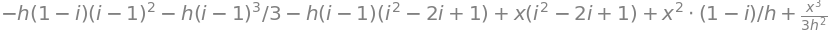

In [177]:
sy_basis2.integrate(x).args[1][0]

In [178]:
sy_dbasis = Derivative(sy_basis, x).doit(); sy_dbasis

⎧ 1                              
⎪ ─   for x > h⋅(i - 1) ∧ x < h⋅i
⎪ h                              
⎪                                
⎨-1                              
⎪───  for x > h⋅i ∧ x < h⋅(i + 1)
⎪ h                              
⎪                                
⎩ 0            otherwise         

In [179]:
sy_dbasis2 = sy_dbasis**2; sy_dbasis2

⎧1                                                                            
⎪──  for (x > h⋅i ∨ x > h⋅(i - 1)) ∧ (x > h⋅i ∨ x < h⋅i) ∧ (x > h⋅(i - 1) ∨ x 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                                       otherwise            
⎩                                                                             

                                        
< h⋅(i + 1)) ∧ (x < h⋅i ∨ x < h⋅(i + 1))
                                        
                                        
                                        
                                        
                                        

In [180]:
sy_dbasis2.piecewise_integrate(x)

⎧x                                                                            
⎪──  for (x > h⋅i ∨ x > h⋅(i - 1)) ∧ (x > h⋅i ∨ x < h⋅i) ∧ (x > h⋅(i - 1) ∨ x 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                                       otherwise            
⎩                                                                             

                                        
< h⋅(i + 1)) ∧ (x < h⋅i ∨ x < h⋅(i + 1))
                                        
                                        
                                        
                                        
                                        

### 1st element of the basis

Consider $\phi_j(x_i)$ with j = 1. Then the integer variable i = j. \
Elements $\phi_0$ and $\phi_n$ are to be defined indipendently from the others with i = 1, ... , n-1.

In [181]:
# Take the general definition of the basis and substitute i = 1
e1 = sy_basis.subs(i, 1); e1

⎧  x                       
⎪  ─     for h > x ∧ x > 0 
⎪  h                       
⎪                          
⎨    x                     
⎪2 - ─  for h < x ∧ x < 2⋅h
⎪    h                     
⎪                          
⎩  0         otherwise     

In [182]:
de1_2 = sy_dbasis2.subs(i,1); de1_2

⎧1                                                                            
⎪──  for (h > x ∨ h < x) ∧ (h > x ∨ x < 2⋅h) ∧ (x > 0 ∨ h < x) ∧ (x > 0 ∨ x < 
⎪ 2                                                                           
⎨h                                                                            
⎪                                                                             
⎪0                                     otherwise                              
⎩                                                                             

    
2⋅h)
    
    
    
    
    

In [183]:
de1_2.integrate((x, 0, 2*h))

And this, my man, is the entry 11 of the stiffness matrix. Time to make this object-oriented and cycle over the indexes.

### Construction of the entries of the K matrix

In [184]:
# Build the main diagonal first
for n in [m+1 for m in range(10)]:
    dummy = sy_dbasis2.subs(i,n).integrate((x, (n-1)*h, (n+1)*h))
    print(dummy)

2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h
2/h


In [191]:
e0 = Piecewise(
    (-x/h+i+1, (x>0)&(x<h)),
    (0, True),
); e0

⎧        x                   
⎪i + 1 - ─  for h > x ∧ x > 0
⎨        h                   
⎪                            
⎩    0          otherwise    

### Last try to see if I can implement some sort of inner product

**Note: the following is just for trying and is not related to the computation of matrix K: in fact, it uses the elements of the basis and not their derivatives.**

In [186]:
# Build the second element of the basis
e2 = sy_basis.subs(i, 2); e2

⎧     x                       
⎪-1 + ─   for h < x ∧ x < 2⋅h 
⎪     h                       
⎪                             
⎨    x                        
⎪3 - ─   for x > 2⋅h ∧ x < 3⋅h
⎪    h                        
⎪                             
⎩  0           otherwise      

**WARNING** \ The result below is by no means correct: this may be due to the order of the 

In [200]:
# Compute the product of e1 and e2
e1e2 = e1*e2; e1e2
e1e2.evalf()

⎛⎧   x                        ⎞ ⎛⎧       x                       ⎞
⎜⎪   ─      for h > x ∧ x > 0 ⎟ ⎜⎪-1.0 + ─   for h < x ∧ x < 2⋅h ⎟
⎜⎪   h                        ⎟ ⎜⎪       h                       ⎟
⎜⎪                            ⎟ ⎜⎪                               ⎟
⎜⎨      x                     ⎟⋅⎜⎨      x                        ⎟
⎜⎪2.0 - ─  for h < x ∧ x < 2⋅h⎟ ⎜⎪3.0 - ─   for x > 2⋅h ∧ x < 3⋅h⎟
⎜⎪      h                     ⎟ ⎜⎪      h                        ⎟
⎜⎪                            ⎟ ⎜⎪                               ⎟
⎝⎩   0          otherwise     ⎠ ⎝⎩   0            otherwise      ⎠

In [198]:
integrate(e1*e2, (x, 0, 2*h))

In [188]:
type(e1e2)

sympy.core.mul.Mul

## B-spline tries

In [189]:
d = 1 # degree pf the B-splines
knots = tuple(range(10)); len(knots)

In [190]:
bspline_basis(d, knots, 7, x)

⎧x - 7  for x ≥ 7 ∧ x ≤ 8
⎪                        
⎨9 - x  for x ≥ 8 ∧ x ≤ 9
⎪                        
⎩  0        otherwise    